In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable # used to identify main plot axis
import geopandas as gdp #reference for Geopandas https://geopandas.org/mapping.html  
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # used to make a smaller axis for cax


In [2]:
# Load Shape Field for US County Map
fp= 'C:/code/us_county/US_County_Boundaries.shp'
map_df = gdp.read_file(fp)

In [3]:
# Data from 2018 FSA Plantings (Jan 2019 report, grain only)
df= pd.read_csv('C:/code/2018_acres_FSA/2018_allcrops_allcounties.csv',
                dtype={"State County Code": str}) #convert FIPs to string for mapping purposes. tutorial from herehttps://plotly.com/python/choropleth-maps/#base-map-configuration 
cols = df.columns.str.replace(' ', '') # change the column names to element spaces
df.columns = cols # replace the column names in the dataframe 
df['PlantedAcres'] = df['PlantedAcres'].str.replace(',','').astype(float) #change so I can sum in the pivot table function 
df.head()

,StateCode,CountyCode,CropCode,State,County,StateCountyCode,Crop,CropType,IntendedUse,IrrigationPractice,PlantedAcres,VolunteerAcres,FailedAcres,PreventedAcres,NotPlantedAcres,PlantedandFailedAcres
0,1,1,11,Alabama,Autauga,01001,WHEAT,SOFT RED WINTER,Grain,N,161.00,0.0000,0.0000,0.0000,0.0000,161.0000
1,1,1,11,Alabama,Autauga,01001,WHEAT,SOFT RED WINTER,Seed,N,26.78,0.0000,0.0000,0.0000,0.0000,26.7800
2,1,1,16,Alabama,Autauga,01001,OATS,HULLESS WINTER,Grazing,N,47.25,0.0000,0.0000,0.0000,0.0000,47.2500
3,1,1,16,Alabama,Autauga,01001,OATS,WINTER,Grain,N,166.19,0.0000,0.0000,0.0000,0.0000,166.1900
4,1,1,16,Alabama,Autauga,01001,OATS,WINTER,Grazing,N,3.37,0.0000,0.0000,0.0000,0.0000,3.3700


In [4]:
#Convert to a table with County and Acres for each croptype
data = pd.pivot_table(df,index=['StateCountyCode'],columns='Crop',values='PlantedAcres',aggfunc=np.sum, fill_value=0)
data = data.reset_index()  # make crop reference number the index 
last = len(data.columns) # create for calling in calculation of total 

# Used this code to determine which column to start counting. Index position 1 for column starts with Alfalfa
#data.iloc[:, 1:]

# Calculating Shannon index, H for species diversity 
 http://www.tiem.utk.edu/~gross/bioed/bealsmodules/shannonDI.html </br>
 http://www.colby.edu/biology/BI131/Lab/Lab09CalcBiodivers.pdf 
 
$diversity= - \sum p_{1}|ln p_{1}|$

$p_{1} =$ proportion of each species relative to the total number of total individuals </br>


In [5]:
# Calculate Shannon's index. Utilized this github resource 
#https://github.com/cbelyea/LRMF-Biodiversity-BAP/blob/master/Large_River_Monitoring_Forum_Biodiversity_Indices_Analysis.ipynb
for i in range(len(data)):
    diversity = 0.0
    for x in range(len(data.iloc[0]))[1:last]:
        if data.iloc[i][x] > 0:
            diversity += -(data.iloc[i][x]/sum(data.iloc[i][1:last][data.iloc[i][1:last]>0])) * math.log((data.iloc[i][x]/sum(data.iloc[i][1:last][data.iloc[i][1:last]>0])))
    data.loc[i,'diversity'] = diversity

In [6]:
#data.info()
#print(data.columns)

In [7]:
# Extract Columns for Mapping, rename StateCountyCode to match base map name
county_diversity = data[['StateCountyCode','diversity']]
county_diversity = county_diversity.rename(columns={'StateCountyCode': 'CTFIPS'})

In [ ]:
county_diversity_adjusted['adj_diversity'] = exp(county_diversity_adjusted)

In [15]:
# Data from 2018 FSA Plantings (Jan 2019 report, grain only)
df= pd.read_csv('C:/code/2018_acres_FSA/2018_fsa_grain_sorghum.csv',
                dtype={"state_county_code": str}) #convert FIPs to string for mapping purposes. tutorial from herehttps://plotly.com/python/choropleth-maps/#base-map-configuration 

df.state_county_code.str = df.state_county_code.str.zfill(5) # added a zero as start to match the json "id"
df = df.rename(columns={'state_county_code': 'CTFIPS'}) #change header name to map county shape file column name

df.tail()
#df.info()

,statecode,countycode,cropcode,state,county,CTFIPS,Crop,crop_type,use,irrigation,acres
2220,56,11,51,Wyoming,Crook,56011,SORGHUM,GRAIN,Grain,N,157.54
2221,56,21,51,Wyoming,Laramie,56021,SORGHUM,GRAIN,Grain,N,27.99
2222,56,27,51,Wyoming,Niobrara,56027,SORGHUM,HYBRID STANDARDPLANT FG,Forage,I,108.14
2223,56,33,51,Wyoming,Sheridan,56033,SORGHUM,GRAIN,Forage,N,5.37
2224,72,13,51,Puerto Rico,Arecibo,72013,SORGHUM,GRAIN,Forage,N,373.02


In [34]:
# Sorghum Acres merged with geopandas frame
acres_map = pd.merge(left=map_df, right=df, on='CTFIPS')
# Plotting points for acres of Sorghum derived from the geometry in merged 
acres_map["x"] = acres_map.centroid.x
acres_map["y"] = acres_map.centroid.y

# Drop Puerto Rico for mapping
acres_map = acres_map.drop(acres_map[acres_map.STATE == 'Puerto Rico'].index)

In [28]:
# Merge geopandas base map and county data
merged = pd.merge(left=map_df, right=county_diversity, on='CTFIPS', how='left')  # left keeps all map_df data and fills with NaNs for right df missing values
merged['diversity']=merged['diversity'].fillna(0) # this is done to map on counties without data for plantings (a couple in Florida, etc)

#Drop all columns for states that will not be mapped 
merged = merged.drop(merged[merged.STATE == 'Hawaii'].index)
merged = merged.drop(merged[merged.STATE == 'Puerto Rico'].index)
merged = merged.drop(merged[merged.STATE == 'Alaska'].index)

# Plot Diversity by County

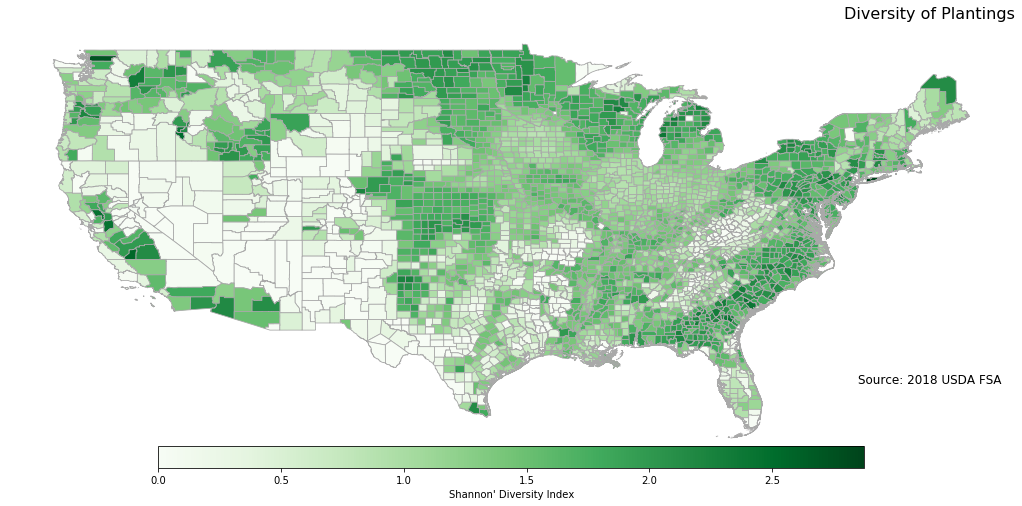

In [13]:
# reference https://geopandas.readthedocs.io/en/latest/mapping.html#creating-a-legend 
# This code has method to append to an axis that is the ratio of the main axis. This is used for colorbar display
fig, ax = plt.subplots(1, figsize=(14, 20))#constrained_layout=True
divider = make_axes_locatable(ax)

cax = inset_axes(ax,
                    width="70%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower center',
                    borderpad=-1)

#cax = divider.append_axes("bottom", size="5%", pad=.3, aspect = 10) 

cmap = 'Greens'

colorscale = ["#171c42","#223f78","#1267b2","#4590c4","#8cb5c9","#b6bed5","#dab2be",
              "#d79d8b","#c46852","#a63329","#701b20","#3c0911"]

plot = merged.plot(column=merged.diversity, 
            cmap= cmap, 
            ax=ax, 
            linewidth=0.8,
            edgecolor='darkgray',
            legend = True,
            legend_kwds={'label': "Shannon' Diversity Index",'panchor':'0.5, 1.0', 'fraction':'.1', 
                           'orientation': "horizontal", 'aspect':'5'}, 
            cax=cax, 
            ) 


#'shrink':'.5', 'fraction':'.046','aspect':'20'
ax.set_title('Diversity of Plantings', size = 16, loc='right')
ax.text(x= -74 , y= 28 , s= 'Source: 2018 USDA FSA', size=12)
ax.legend = True 
ax.set_axis_off()
ax.axis = ('equal')
plt.axis("tight")
plt.subplots_adjust(left=0, right=1, bottom=0, top=1) # this is not compatiple with contrained layout
plt.savefig('County_Diversity_Index_FSA18', bbox_inches='tight', dpi=200, pad_inches = 0)
plt.show()

# Diversity with Sorghum Acres 

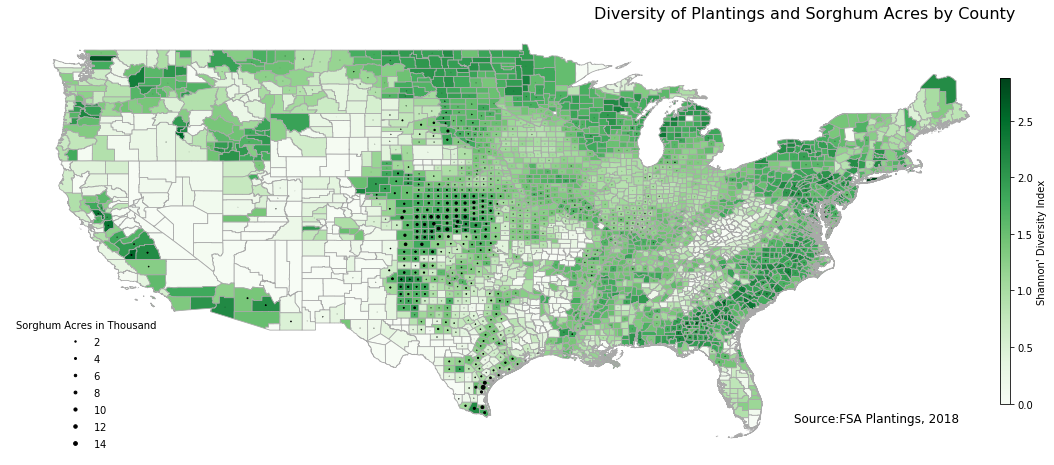

In [42]:
# reference https://geopandas.readthedocs.io/en/latest/mapping.html#creating-a-legend 
# This code has method to append to an axis that is the ratio of the main axis. This is used for colorbar display
fig, ax = plt.subplots(1, figsize=(14, 20))#constrained_layout=True
divider = make_axes_locatable(ax)

cax = inset_axes(ax,
                    width="1%",  # width = 50% of parent_bbox width
                    height="75%",  # height : 5%
                    loc='right')


cmap = 'Greens'

plot = merged.plot(column=merged.diversity, 
            cmap= cmap, 
            ax=ax, 
            linewidth=0.8,
            edgecolor='darkgray',
            legend = True,
            legend_kwds={'label': "Shannon' Diversity Index",'panchor':'0.5, 1.0', 'fraction':'.1', 
                            'orientation': "vertical"}, 
            cax=cax, 
            ) 

# Sorghum Acres by County Scatter Plot
x, y = acres_map['x'].values, acres_map['y'].values
scatter = ax.scatter(x, y, marker="o", c ='black', zorder=5, s=acres_map.acres*.0001, alpha = 1)

handles, labels = scatter.legend_elements(prop="sizes")
legend1 = ax.legend(handles, labels, loc="lower left", title="Sorghum Acres in Thousand", frameon=False)

ax.legend = True 

ax.set_title('Diversity of Plantings and Sorghum Acres by County', size = 16, loc='right')
ax.text(x= -78 , y= 25.5 , s= 'Source:FSA Plantings, 2018', size=12)

ax.set_axis_off()
ax.axis = ('equal')

plt.subplots_adjust(left=0, right=1, bottom=0, top=1) # this is not compatiple with contrained layout
plt.savefig('Sorghum_County_Diversity_Index_FSA18', bbox_inches='tight', dpi=200, pad_inches = 0)
plt.show()